In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

# import pytorch_ssim

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
import os

In [11]:
# #from google.colab import files
# from google.colab import drive
# files.upload()
# drive.mount('/content/gdrive')
# !unzip train.zip
# !unzip val.zip
# !unzip /content/gdrive/MyDrive/data.zip

In [12]:
# Import custom modules
import process
import loader
import network
from importlib import reload

if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU")
else:
    device = 'cpu'
    print("Using CPU")

Using GPU


In [13]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance

# data loading
train_dir = 'train/images'
val_dir = 'val/images'
train_imgs = loader.image_loader(train_dir, 10000)
val_test_imgs = loader.image_loader(val_dir, 6000)
val_imgs = val_test_imgs[:3000]
test_imgs = val_test_imgs[3000:]

print("Done!")
print(f"Train imgs count: {len(train_imgs)}")
print(f"Val imgs count: {len(val_test_imgs)}")

train_L = process.imgs_tensor(train_imgs)
val_L = process.imgs_tensor(val_imgs)
test_L = process.imgs_tensor(test_imgs)

Loading datasets...
Loading images from train/images...
Loading images from val/images...
Done!
Train imgs count: 10000
Val imgs count: 6000


In [14]:
# Create dataloaders
# Experiment with different batch sizes
batch_size=512
trainloader = DataLoader(train_L, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_L, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_L, batch_size=batch_size, shuffle=True)

In [15]:
# Load model
network = reload(network)
# model = network.Small()
network_channels = [32,64,128]

dropout=0.4
# model = network.Small()
network_channels = [32,64,128]
kernel_size = 5
batch_norm = True 
model = network.Small(
            dropout=dropout, 
            kernel_size=kernel_size,
            downscale_by=2,
            batch_norm=batch_norm,
            activation=torch.nn.ReLU
        ).to(device)

# network_channels = [32,64,128,128]
# model = network.UNet(
#         in_channels=1,
#         layer_channels=network_channels,
#         out_channels=[2,64,128,128],
#         downsample_scale=2,
#         kernel_size=5,
#         n_convs_per_layer = 2, 
#         dropout=0.3
#     ).to(device)

print('Your network:')
# print(summary(model, (1,64,64),device=device)) # visualize your model
criterion = nn.MSELoss() # WE MODIFIED LOSS FUNCTION

# Set up optimization hyperparameters
learning_rate = 1e-3
weight_decay = 5e-5
num_epoch = 50
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)

def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_loss_hist_fine = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print(f'-----------------Epoch = {i}/{num_epoch}-----------------')
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = nn.functional.mse_loss(pred,label) # criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
            trn_loss_hist_fine.append(loss.item())
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist,trn_loss_hist_fine, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    running_acc = []
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            ssim = SSIM().to(device)
            ssim_acc = ssim(pred, label).to(device)
            running_acc.append(ssim_acc.item())
        acc = np.mean(running_acc)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist,fine_trn_losses, trn_acc_hist, val_acc_hist = train(model.to(device), trainloader,
                                                  valloader, num_epoch)


model = model.cpu()

# Note down the evaluation accuracy on test set
print("\n Evaluate on test set")
evaluate(model.to(device), testloader)
model = model.cpu()


Your network:
Start training...
-----------------Epoch = 0/50-----------------


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 20/20 [00:13<00:00,  1.48it/s]



 Epoch 1 loss:274.7470420837402


100%|██████████| 20/20 [00:01<00:00, 12.13it/s]



 Evaluation accuracy: 0.16372610703110696

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.51it/s]



 Evaluation accuracy: 0.16004507740338644
-----------------Epoch = 1/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]



 Epoch 2 loss:251.60445556640624


100%|██████████| 20/20 [00:01<00:00, 12.06it/s]



 Evaluation accuracy: 0.2243965081870556

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]



 Evaluation accuracy: 0.22057615468899408
-----------------Epoch = 2/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.53it/s]



 Epoch 3 loss:241.75889511108397


100%|██████████| 20/20 [00:01<00:00, 12.54it/s]



 Evaluation accuracy: 0.2419001989066601

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.46it/s]



 Evaluation accuracy: 0.23807663222153982
-----------------Epoch = 3/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.56it/s]



 Epoch 4 loss:240.02790908813478


100%|██████████| 20/20 [00:01<00:00, 12.53it/s]



 Evaluation accuracy: 0.2540649302303791

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.61it/s]



 Evaluation accuracy: 0.25381884972254437
-----------------Epoch = 4/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]



 Epoch 5 loss:238.1459991455078


100%|██████████| 20/20 [00:01<00:00, 12.18it/s]



 Evaluation accuracy: 0.2611273653805256

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.88it/s]



 Evaluation accuracy: 0.2590770522753398
-----------------Epoch = 5/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]



 Epoch 6 loss:238.86160049438476


100%|██████████| 20/20 [00:01<00:00, 12.42it/s]



 Evaluation accuracy: 0.2549382269382477

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.48it/s]



 Evaluation accuracy: 0.25261454780896503
-----------------Epoch = 6/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.17it/s]



 Epoch 7 loss:236.02453384399413


100%|██████████| 20/20 [00:01<00:00, 11.83it/s]



 Evaluation accuracy: 0.25330877751111985

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.97it/s]



 Evaluation accuracy: 0.2516222894191742
-----------------Epoch = 7/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]



 Epoch 8 loss:235.9423973083496


100%|██████████| 20/20 [00:01<00:00, 12.30it/s]



 Evaluation accuracy: 0.25191525369882584

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.40it/s]



 Evaluation accuracy: 0.2477560689051946
-----------------Epoch = 8/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]



 Epoch 9 loss:233.57067642211913


100%|██████████| 20/20 [00:01<00:00, 12.24it/s]



 Evaluation accuracy: 0.24278439506888388

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.01it/s]



 Evaluation accuracy: 0.2444463074207306
-----------------Epoch = 9/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.28it/s]



 Epoch 10 loss:234.36509704589844


100%|██████████| 20/20 [00:01<00:00, 11.90it/s]



 Evaluation accuracy: 0.2611469134688377

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.87it/s]



 Evaluation accuracy: 0.2549697508414586
-----------------Epoch = 10/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.26it/s]



 Epoch 11 loss:231.57826309204103


100%|██████████| 20/20 [00:01<00:00, 12.06it/s]



 Evaluation accuracy: 0.2643235355615616

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 12.07it/s]



 Evaluation accuracy: 0.2582731495300929
-----------------Epoch = 11/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.27it/s]



 Epoch 12 loss:230.69083938598632


100%|██████████| 20/20 [00:01<00:00, 11.97it/s]



 Evaluation accuracy: 0.2542561538517475

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.97it/s]



 Evaluation accuracy: 0.2520502631862958
-----------------Epoch = 12/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]



 Epoch 13 loss:229.36902618408203


100%|██████████| 20/20 [00:01<00:00, 11.90it/s]



 Evaluation accuracy: 0.27218384817242625

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.95it/s]



 Evaluation accuracy: 0.26774314045906067
-----------------Epoch = 13/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.17it/s]



 Epoch 14 loss:227.05995025634766


100%|██████████| 20/20 [00:01<00:00, 11.88it/s]



 Evaluation accuracy: 0.2697108879685402

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.95it/s]



 Evaluation accuracy: 0.2639339690407117
-----------------Epoch = 14/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]



 Epoch 15 loss:228.48159408569336


100%|██████████| 20/20 [00:02<00:00, 10.00it/s]



 Evaluation accuracy: 0.2534632503986359

 Evaluate on validation set...


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]



 Evaluation accuracy: 0.24749346325794855
-----------------Epoch = 15/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]



 Epoch 16 loss:224.89398040771485


100%|██████████| 20/20 [00:01<00:00, 11.75it/s]



 Evaluation accuracy: 0.26828096210956576

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.73it/s]



 Evaluation accuracy: 0.2595461482803027
-----------------Epoch = 16/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]



 Epoch 17 loss:225.7187530517578


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]



 Evaluation accuracy: 0.2828588992357254

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.26it/s]



 Evaluation accuracy: 0.27409100035826367
-----------------Epoch = 17/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.95it/s]



 Epoch 18 loss:226.2416748046875


100%|██████████| 20/20 [00:01<00:00, 11.61it/s]



 Evaluation accuracy: 0.2819858521223068

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.61it/s]



 Evaluation accuracy: 0.273404136300087
-----------------Epoch = 18/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]



 Epoch 19 loss:222.36724243164062


100%|██████████| 20/20 [00:01<00:00, 11.49it/s]



 Evaluation accuracy: 0.279876221716404

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.67it/s]



 Evaluation accuracy: 0.27000202735265094
-----------------Epoch = 19/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.91it/s]



 Epoch 20 loss:223.020499420166


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]



 Evaluation accuracy: 0.24303719028830528

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.54it/s]



 Evaluation accuracy: 0.23767713208993277
-----------------Epoch = 20/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]



 Epoch 21 loss:223.08246536254882


100%|██████████| 20/20 [00:01<00:00, 11.45it/s]



 Evaluation accuracy: 0.27127656564116476

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.54it/s]



 Evaluation accuracy: 0.25982750952243805
-----------------Epoch = 21/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]



 Epoch 22 loss:217.10222244262695


100%|██████████| 20/20 [00:01<00:00, 11.19it/s]



 Evaluation accuracy: 0.2800461634993553

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.08it/s]



 Evaluation accuracy: 0.2640945067008336
-----------------Epoch = 22/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]



 Epoch 23 loss:214.75201416015625


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]



 Evaluation accuracy: 0.29955989867448807

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.66it/s]



 Evaluation accuracy: 0.27992692589759827
-----------------Epoch = 23/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]



 Epoch 24 loss:207.05363006591796


100%|██████████| 20/20 [00:01<00:00, 11.59it/s]



 Evaluation accuracy: 0.2893590584397316

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.56it/s]



 Evaluation accuracy: 0.26732730368773144
-----------------Epoch = 24/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]



 Epoch 25 loss:205.83715057373047


100%|██████████| 20/20 [00:01<00:00, 11.59it/s]



 Evaluation accuracy: 0.28910576105117797

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.68it/s]



 Evaluation accuracy: 0.26097682615121204
-----------------Epoch = 25/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]



 Epoch 26 loss:199.00464096069337


100%|██████████| 20/20 [00:01<00:00, 11.70it/s]



 Evaluation accuracy: 0.30688229501247405

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]



 Evaluation accuracy: 0.2685852150122325
-----------------Epoch = 26/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]



 Epoch 27 loss:191.56005096435547


100%|██████████| 20/20 [00:01<00:00, 11.55it/s]



 Evaluation accuracy: 0.3051421269774437

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.50it/s]



 Evaluation accuracy: 0.2701677034298579
-----------------Epoch = 27/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]



 Epoch 28 loss:186.48826522827147


100%|██████████| 20/20 [00:01<00:00, 11.76it/s]



 Evaluation accuracy: 0.3029687002301216

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.75it/s]



 Evaluation accuracy: 0.26158824066321057
-----------------Epoch = 28/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]



 Epoch 29 loss:179.08871612548828


100%|██████████| 20/20 [00:01<00:00, 11.74it/s]



 Evaluation accuracy: 0.3281247317790985

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.72it/s]



 Evaluation accuracy: 0.26370517909526825
-----------------Epoch = 29/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]



 Epoch 30 loss:169.2483772277832


100%|██████████| 20/20 [00:01<00:00, 11.58it/s]



 Evaluation accuracy: 0.331795896589756

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.68it/s]



 Evaluation accuracy: 0.25629010796546936
-----------------Epoch = 30/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.03it/s]



 Epoch 31 loss:161.45320205688478


100%|██████████| 20/20 [00:01<00:00, 11.61it/s]



 Evaluation accuracy: 0.34744140803813933

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.86it/s]



 Evaluation accuracy: 0.263430359462897
-----------------Epoch = 31/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.03it/s]



 Epoch 32 loss:159.25446701049805


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]



 Evaluation accuracy: 0.32123026698827745

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.38it/s]



 Evaluation accuracy: 0.24472306668758392
-----------------Epoch = 32/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]



 Epoch 33 loss:153.16733932495117


100%|██████████| 20/20 [00:01<00:00, 11.60it/s]



 Evaluation accuracy: 0.3589769944548607

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.71it/s]



 Evaluation accuracy: 0.2608431528011958
-----------------Epoch = 33/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]



 Epoch 34 loss:145.40504989624023


100%|██████████| 20/20 [00:01<00:00, 11.52it/s]



 Evaluation accuracy: 0.37180678844451903

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.23it/s]



 Evaluation accuracy: 0.25943318506081897
-----------------Epoch = 34/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.90it/s]



 Epoch 35 loss:141.82340469360352


100%|██████████| 20/20 [00:01<00:00, 11.60it/s]



 Evaluation accuracy: 0.3766238078474998

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.71it/s]



 Evaluation accuracy: 0.25304994483788806
-----------------Epoch = 35/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]



 Epoch 36 loss:138.63493461608886


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]



 Evaluation accuracy: 0.36971802115440366

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.58it/s]



 Evaluation accuracy: 0.258477620780468
-----------------Epoch = 36/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.97it/s]



 Epoch 37 loss:131.41137237548827


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]



 Evaluation accuracy: 0.3867557540535927

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.46it/s]



 Evaluation accuracy: 0.2534835984309514
-----------------Epoch = 37/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]



 Epoch 38 loss:127.43330230712891


100%|██████████| 20/20 [00:01<00:00, 11.50it/s]



 Evaluation accuracy: 0.3990353927016258

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.73it/s]



 Evaluation accuracy: 0.25541754563649494
-----------------Epoch = 38/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]



 Epoch 39 loss:122.50495338439941


100%|██████████| 20/20 [00:01<00:00, 11.45it/s]



 Evaluation accuracy: 0.4062734767794609

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.44it/s]



 Evaluation accuracy: 0.25012098749478656
-----------------Epoch = 39/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]



 Epoch 40 loss:117.91509666442872


100%|██████████| 20/20 [00:01<00:00, 11.51it/s]



 Evaluation accuracy: 0.4140492632985115

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.78it/s]



 Evaluation accuracy: 0.2498528336485227
-----------------Epoch = 40/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]



 Epoch 41 loss:113.65878829956054


100%|██████████| 20/20 [00:01<00:00, 11.54it/s]



 Evaluation accuracy: 0.4165548771619797

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.70it/s]



 Evaluation accuracy: 0.24803833911816278
-----------------Epoch = 41/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.96it/s]



 Epoch 42 loss:109.63568344116212


100%|██████████| 20/20 [00:01<00:00, 11.15it/s]



 Evaluation accuracy: 0.42170934975147245

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.47it/s]



 Evaluation accuracy: 0.25017183770736057
-----------------Epoch = 42/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.00it/s]



 Epoch 43 loss:106.0464298248291


100%|██████████| 20/20 [00:01<00:00, 11.50it/s]



 Evaluation accuracy: 0.4382715210318565

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.67it/s]



 Evaluation accuracy: 0.24667713542779288
-----------------Epoch = 43/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]



 Epoch 44 loss:102.96505889892578


100%|██████████| 20/20 [00:01<00:00, 11.38it/s]



 Evaluation accuracy: 0.4423004314303398

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.69it/s]



 Evaluation accuracy: 0.24216687679290771
-----------------Epoch = 44/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]



 Epoch 45 loss:100.58699569702148


100%|██████████| 20/20 [00:01<00:00, 11.54it/s]



 Evaluation accuracy: 0.45061926394701

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.78it/s]



 Evaluation accuracy: 0.24447631339232126
-----------------Epoch = 45/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.03it/s]



 Epoch 46 loss:99.30668067932129


100%|██████████| 20/20 [00:01<00:00, 11.58it/s]



 Evaluation accuracy: 0.45183291137218473

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.78it/s]



 Evaluation accuracy: 0.23843971143166223
-----------------Epoch = 46/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.98it/s]



 Epoch 47 loss:96.03070526123047


100%|██████████| 20/20 [00:01<00:00, 11.47it/s]



 Evaluation accuracy: 0.45985953956842424

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.69it/s]



 Evaluation accuracy: 0.24685141692558923
-----------------Epoch = 47/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]



 Epoch 48 loss:96.90401306152344


100%|██████████| 20/20 [00:01<00:00, 11.66it/s]



 Evaluation accuracy: 0.41822228133678435

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.61it/s]



 Evaluation accuracy: 0.24843969196081161
-----------------Epoch = 48/50-----------------


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]



 Epoch 49 loss:97.5811580657959


100%|██████████| 20/20 [00:01<00:00, 11.41it/s]



 Evaluation accuracy: 0.46084762960672376

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.20it/s]



 Evaluation accuracy: 0.2471244732538859
-----------------Epoch = 49/50-----------------


100%|██████████| 20/20 [00:03<00:00,  5.99it/s]



 Epoch 50 loss:91.8976448059082


100%|██████████| 20/20 [00:01<00:00, 11.64it/s]



 Evaluation accuracy: 0.4745412215590477

 Evaluate on validation set...


100%|██████████| 6/6 [00:00<00:00, 11.69it/s]



 Evaluation accuracy: 0.24694300442934036
Done!

 Evaluate on test set


100%|██████████| 6/6 [00:00<00:00, 11.63it/s]


 Evaluation accuracy: 0.24713543305794397


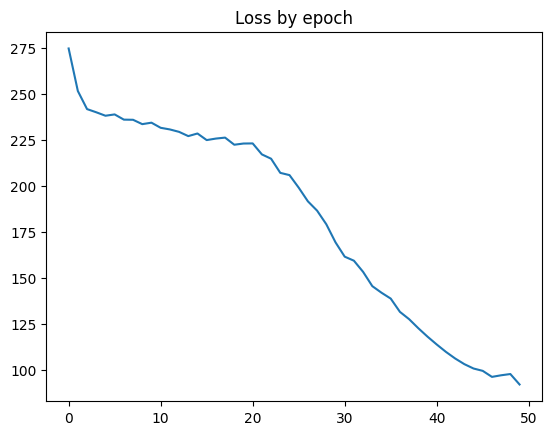

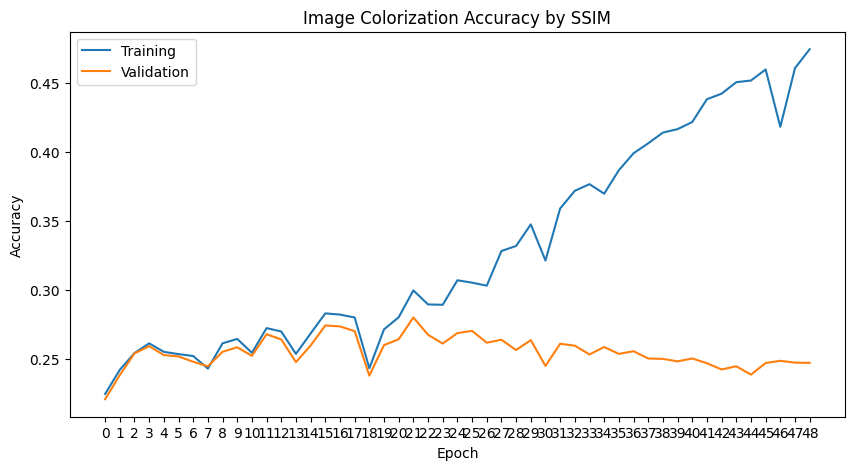

In [16]:
if type(model) is network.UNet: 
    model_name = f'UNet_{learning_rate:1.2e}_epoch_{num_epoch}_dropout_{dropout}_{"_".join(str(ch) for ch in network_channels)}'
else: 
    model_name = f'small_{learning_rate:1.2e}_epoch_{num_epoch}_dropout_{dropout}_ks_{kernel_size}_bn_{batch_norm}'

os.makedirs('model_saves',exist_ok=True)
torch.save(model,f'model_saves/{model_name}.pt')
# Submit the accuracy plot

# Submit the accuracy plot
# visualize the training / validation accuracies
plt.figure()
plt.plot(trn_loss_hist)
plt.title('Loss by epoch')
plt.plot()


x = np.arange(num_epoch -1)
plt.figure()
plt.plot(x, trn_acc_hist[1:])
plt.plot(x, val_acc_hist[1:])
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Image Colorization Accuracy by SSIM')
plt.gcf().set_size_inches(10, 5)
os.makedirs('figures_out',exist_ok=True)
plt.savefig(f'figures_out/training_curve_{model_name}.jpg')
plt.savefig('.png', dpi=300)

plt.show()

In [17]:
model.eval()
# sample = loader.load_img('val/images/val_1009.JPEG')
sample = loader.load_img('val/images/val_1003.JPEG')
def make_comparison(model,model_name,img_path,save=True):
  sample = loader.load_img(img_path)
  tens_l_orig, tens_l_rs, ab_vals = process.preprocess_img(sample, HW=(64,64), resample=3)
  tens_l_rs = tens_l_rs# .to(device)


  img_bw = process.postprocess(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
  out_img = process.postprocess(tens_l_orig, model(tens_l_rs).cpu())

  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1)
  plt.imshow(sample)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(img_bw)
  plt.title('Input')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(out_img)
  plt.title('Output Colorized')
  plt.axis('off')
  if save: 
    os.makedirs('figures_out',exist_ok=True)
    plt.savefig(f'figures_out/imgs_{img_path.split("/")[-1]}_{model_name}.jpg')

  plt.show()

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


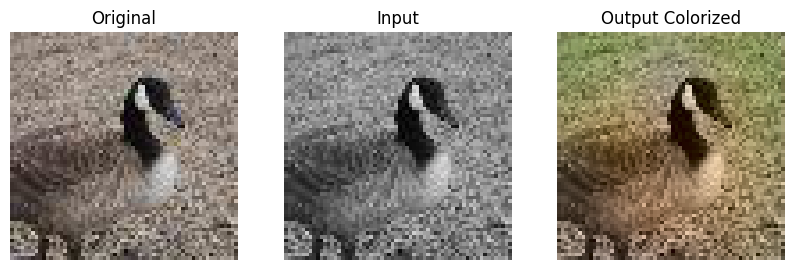

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


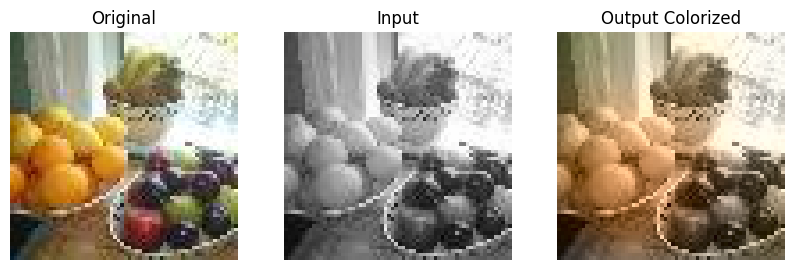

In [18]:
make_comparison(model,model_name,'val/images/val_1009.JPEG')
make_comparison(model,model_name,'train/images/test_15.JPEG',save=False)

6981


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)


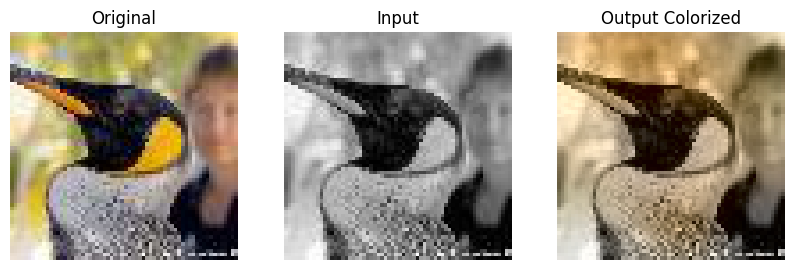

7540


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


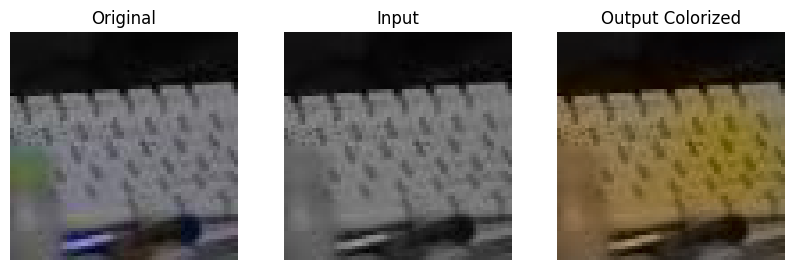

2490


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


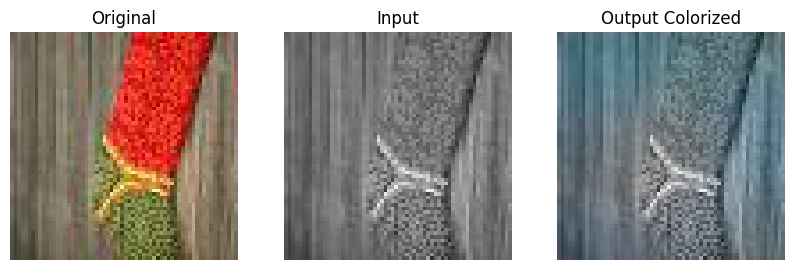

2451


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


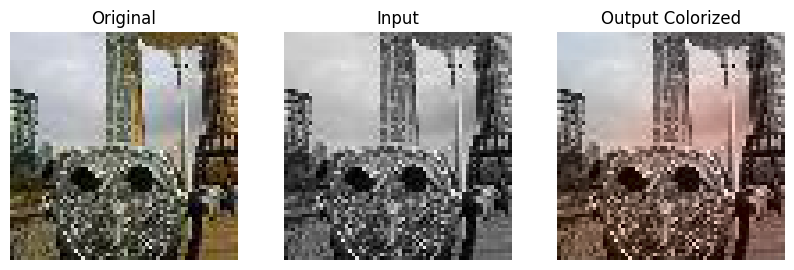

658


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)


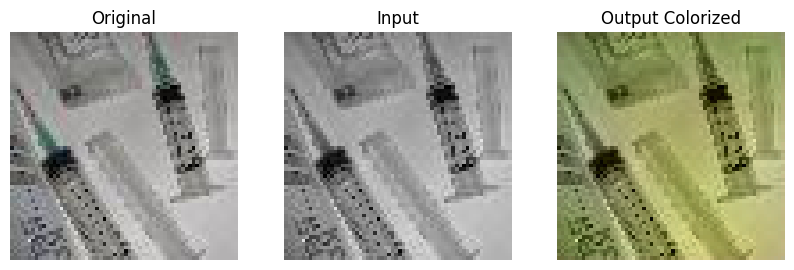

3787


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


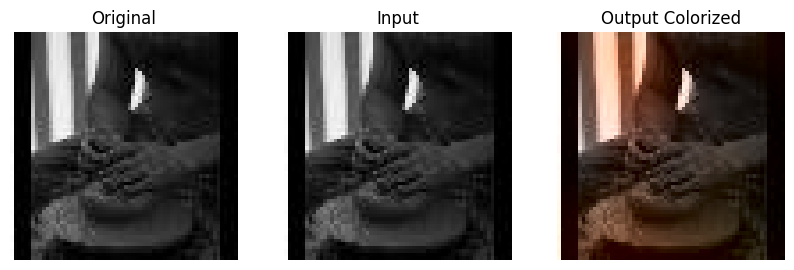

3933


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


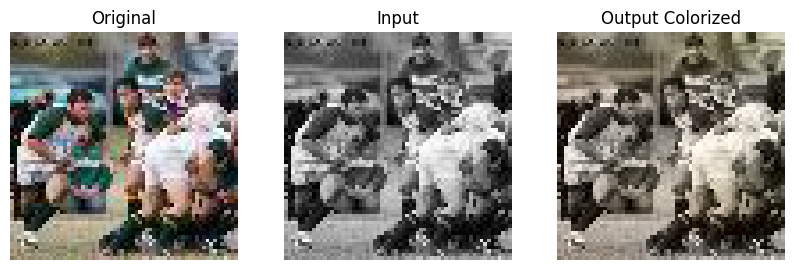

5436


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


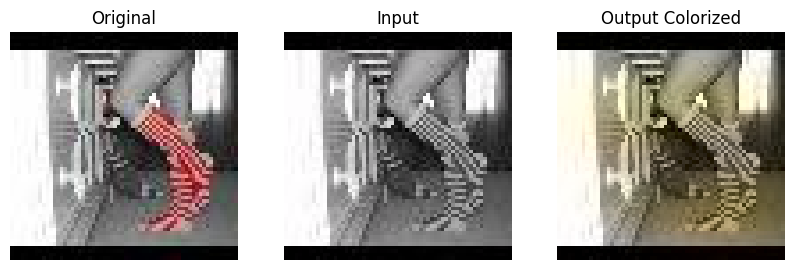

2459


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


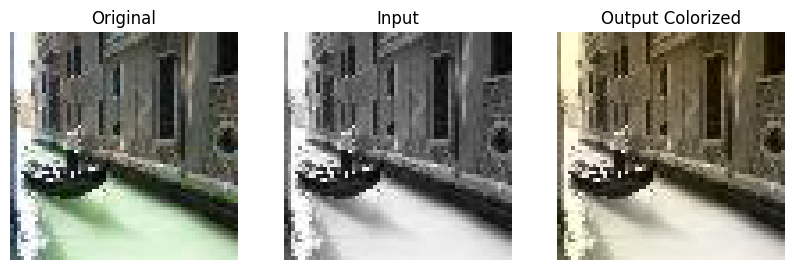

7120


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


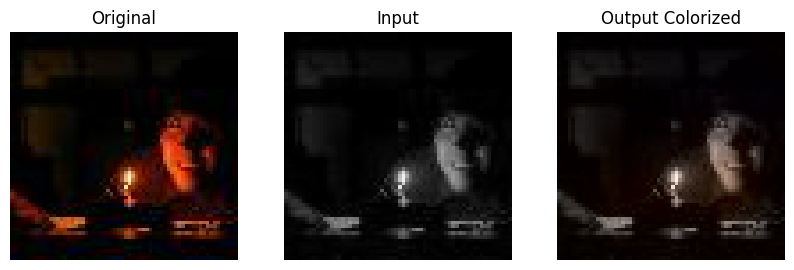

544


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


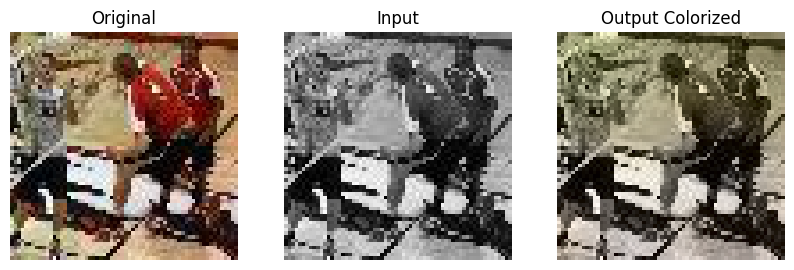

8982


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


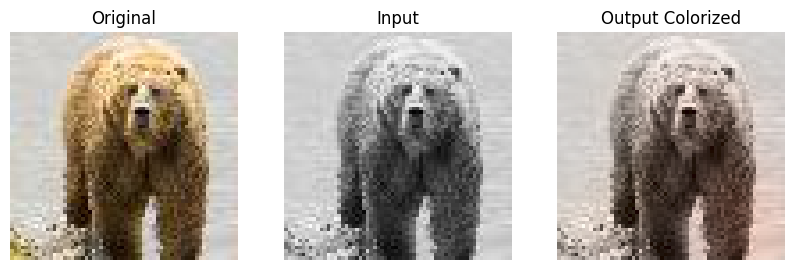

8802


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


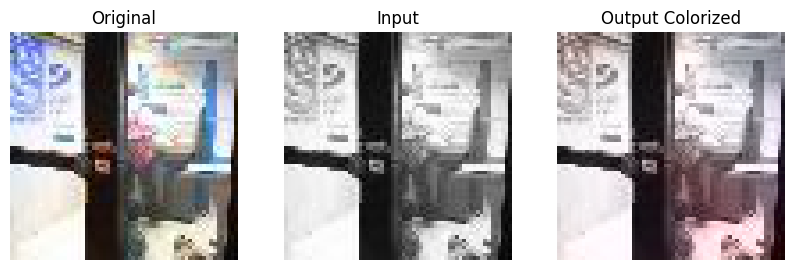

1822


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


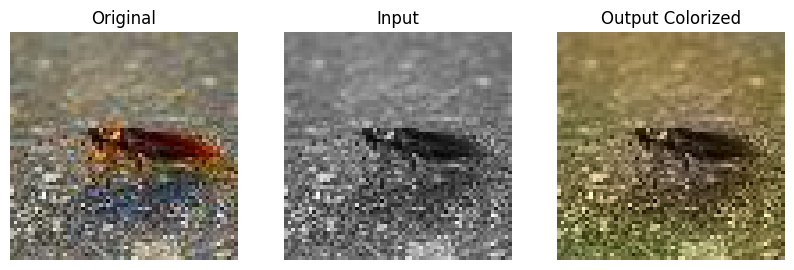

7522


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


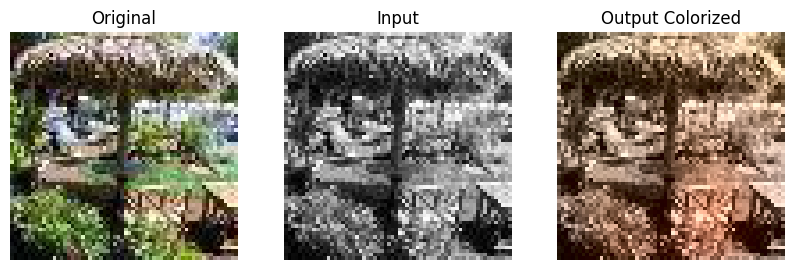

642


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


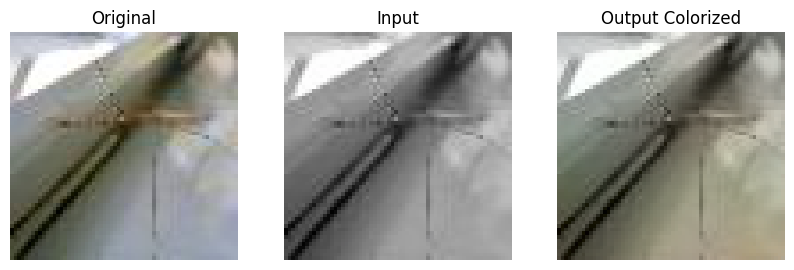

3734


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


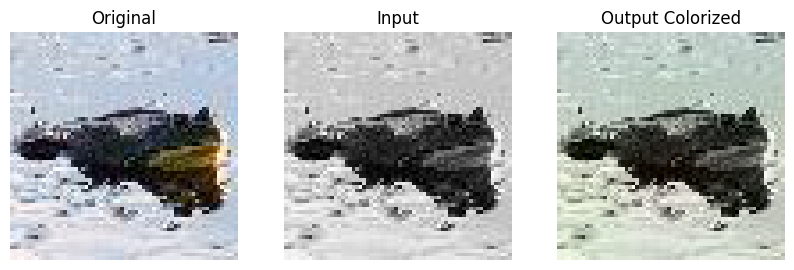

3016


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


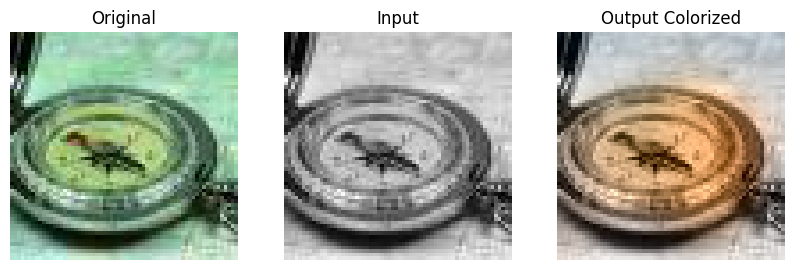

886


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


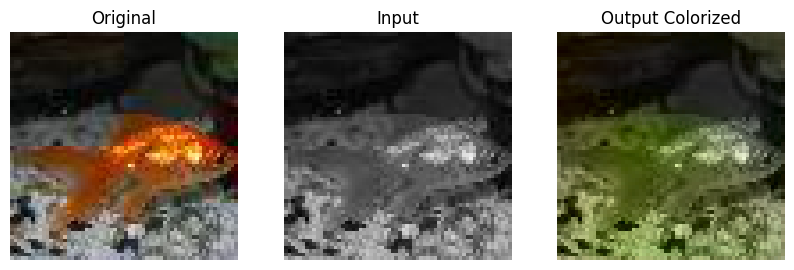

7856


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


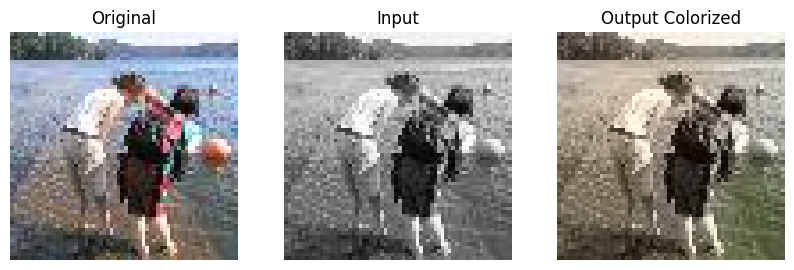

In [19]:
np.random.seed(46)
for i in range(20): 
  img_num = np.random.randint(0,10000)
  print(img_num)
  make_comparison(model,model_name,f'val/images/val_{img_num}.JPEG')